<a href="https://colab.research.google.com/github/andiylan/Microexpression/blob/main/LBPSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.color import rgb2gray

In [2]:

from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


# **Konfigurasi Gabor Filter**

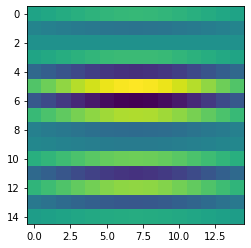

In [116]:
ksize = 15 #ukuran kernel
sigma = 5 #bobot fitur
theta = 1*np.pi/2  #orientasi
lamda = 3*np.pi/4  #arah orientasi
gamma = 0.9  #aspect ratio
phi = 0.8  #offset

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
plt.imshow(kernel)

# **Prepare Dataset**


*   adding Median Filter
*   adding Gabor Filter



In [195]:
dataset_folder = "/content/drive/MyDrive/SMIC/Train/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    for name in os.listdir(os.path.join(dataset_folder, folder)):
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            #img = cv2.medianBlur(img, 3)
            #img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            #kernel_resized = cv2.resize(kernel,(400,400))
            img = cv2.resize(img, (100, 100))
            img = rgb2gray(img)
            images.append(img)
            names.append(folder)

In [196]:
labels=np.unique(names)
labels

array(['negative', 'positive', 'surprise'], dtype='<U8')

In [197]:
def show_dataset(images_class, label):
    # show data for 1 class
    plt.figure(figsize=(14,5))
    k = 0
    for i in range(1,6):
        plt.subplot(1,5,i)
        try :
            plt.imshow(images_class[k][:,:,:,:-1])
        except :
            plt.imshow(images_class[k],cmap='gray')
        plt.title(label)
        plt.axis('off')
        plt.tight_layout()
        k += 1
    plt.show()

# **Show 5 sample from each class**

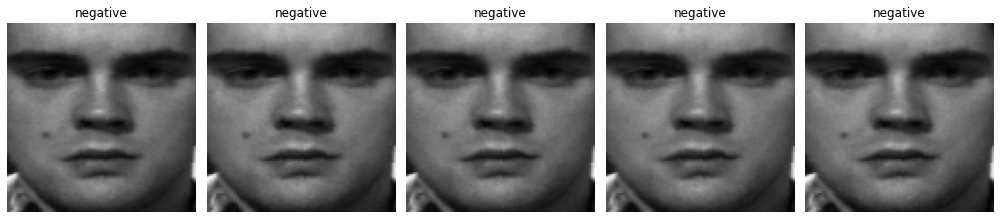

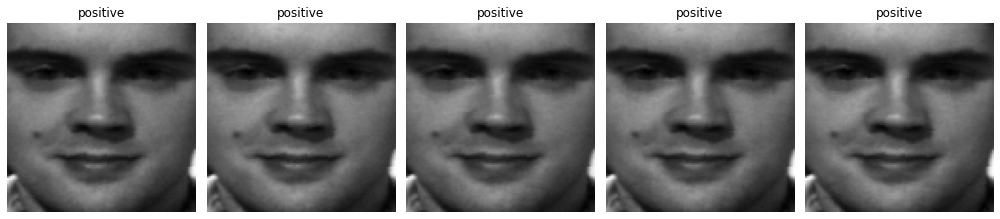

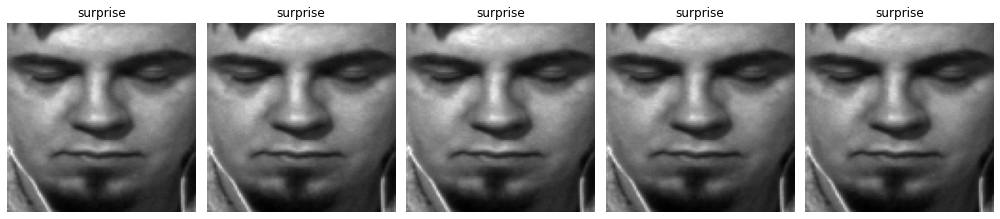

In [198]:
for label in labels:
    
    ids = np.where(label== np.array(names))[0]
    images_class = images[ids[0] : ids[-1] + 1] # select croped images for each class
    show_dataset(images_class, label)

# **Label Encoding**

In [199]:
from sklearn.preprocessing import LabelEncoder

In [200]:
le = LabelEncoder()

le.fit(names)

LabelEncoder()

In [201]:
name_vec=le.transform(names)

In [202]:
name_vec

array([1, 1, 1, ..., 0, 0, 0])

# **Split the Dataset**

In [203]:
from sklearn.model_selection import train_test_split

In [204]:
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    np.array(name_vec),
                                                    test_size=0.25, 
                                                    random_state=42)

In [205]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2902, 100, 100), (2902,), (968, 100, 100), (968,))

# **Feature Extractor Using LBP in scikit image**

In [206]:
from skimage.feature import local_binary_pattern

In [207]:
P = 8 
R = 1
img = x_train[0]
lbp_img = local_binary_pattern(img, P=P, R=R, method="default")

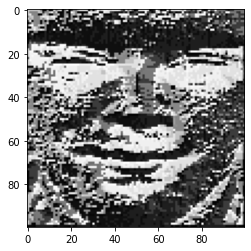

In [208]:
plt.imshow(lbp_img, cmap="gray")

In [209]:
H = np.histogram(lbp_img.ravel(),                          
                 bins=2**P,                          
                 range=(0, 2**P),
                 density=True)[0] 

In [210]:
print(H)

[0.03 0.01 0.   0.01 0.01 0.   0.01 0.02 0.   0.   0.   0.   0.01 0.
 0.03 0.06 0.01 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
 0.03 0.   0.07 0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.02 0.   0.   0.   0.04 0.   0.03 0.01 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.02 0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.01 0.
 0.01 0.   0.   0.01 0.   0.01 0.   0.   0.   0.03 0.   0.   0.   0.
 0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.02
 0.   0.   0.   0.01 0.   0.   0

*Plot Feature Histogram*






<function matplotlib.pyplot.show>

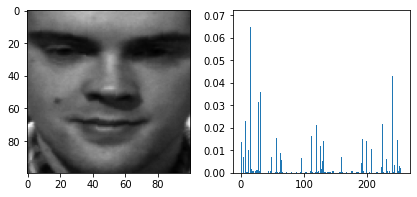

In [211]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
axis = np.arange(len(H))
plt.bar(axis, H)

plt.show

# **Train Dataset Using SVM**

In [212]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [213]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 6))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [214]:
class LBPH_SVM_Recognizer_V1():
    #class for LBPH Scikit + SVM OpenCV

    def __init__(self, max_iter=100, epsilon=0.001, C=100, Gamma=0.001):
        self.svm = cv2.ml.SVM_create()
        self.svm.setKernel(cv2.ml.SVM_RBF)
        self.svm.setType(cv2.ml.SVM_C_SVC)
        self.svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon))
        self.svm.setC(C)           
        self.svm.setGamma(Gamma) 
        
        self.face_histograms = []
        self.y = []
    
    def find_lbp_histogram(self, image, P=8, R=1, eps=1e-7, n_window=(8,8)):
        E = []
        h, w = image.shape
        h_sz = int(np.floor(h/n_window[0]))
        w_sz = int(np.floor(w/n_window[1]))
        lbp_img = local_binary_pattern(image, P=P, R=R, method="default")
        for (x, y, C) in self.sliding_window(lbp_img, stride=(h_sz, w_sz), window=(h_sz, w_sz)):
            if C.shape[0] != h_sz or C.shape[1] != w_sz:
                continue
            H = np.histogram(C,                          
                             bins=2**P, 
                             range=(0, 2**P),
                             density=True)[0] 
            E.extend(H)
        return E
    
    def sliding_window(self, image, stride, window):
        for y in range(0, image.shape[0], stride[0]):
            for x in range(0, image.shape[1], stride[1]):
                yield (x, y, image[y:y + window[1], x:x + window[0]])
                   
    def train(self, x, y):
        self.y = y
        self.face_histograms = [self.find_lbp_histogram(img) for img in x]
        hist_mat = np.array(self.face_histograms, dtype=np.float32)
        self.svm.train(hist_mat, cv2.ml.ROW_SAMPLE, y)
    
    def predict(self, x):
        hists = [self.find_lbp_histogram(img) for img in x]
        hist_mat = np.array(hists, dtype=np.float32)
        ret, idx = self.svm.predict(hist_mat, True)
        confidence = 1.0 / (1.0 + np.exp(-ret)) # convert retVal to confidence level (0-1) sigmoid
        return idx, confidence

In [215]:
lbph_svm_model_v1 = LBPH_SVM_Recognizer_V1()

In [216]:
lbph_svm_model_v1.train(x_train, y_train)

In [217]:
lbph_svm_model_v1.svm.save("lbph_svm_model_v1.yml")
lbph_svm_model_v1.svm.load("lbph_svm_model_v1.yml")

<ml_SVM 0x7f275f514690>

In [218]:
y_predict = lbph_svm_model_v1.predict(x_test)[0]

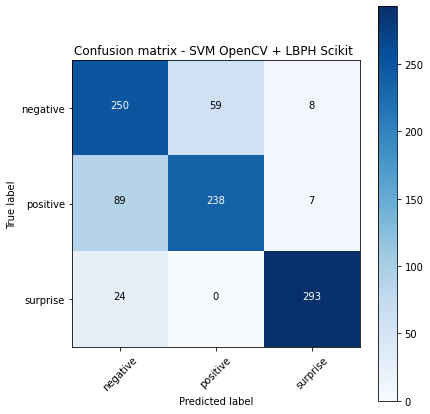

In [219]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix - SVM OpenCV + LBPH Scikit ')

In [220]:
print("== Classification Report - SVM OpenCV + LBPH Scikit ==\n")
print(classification_report(y_test, 
                            y_predict, 
                            target_names=labels))

== Classification Report - SVM OpenCV + LBPH Scikit ==

              precision    recall  f1-score   support

    negative       0.69      0.79      0.74       317
    positive       0.80      0.71      0.75       334
    surprise       0.95      0.92      0.94       317

    accuracy                           0.81       968
   macro avg       0.81      0.81      0.81       968
weighted avg       0.81      0.81      0.81       968

